In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as w
import explore as e
import model as m
from scipy import stats
from importlib import reload
import warnings
from sklearn.preprocessing import RobustScaler, MinMaxScaler
warnings.simplefilter("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [11]:
reload(w)
train, validate,test = w.wrangle_coasters()


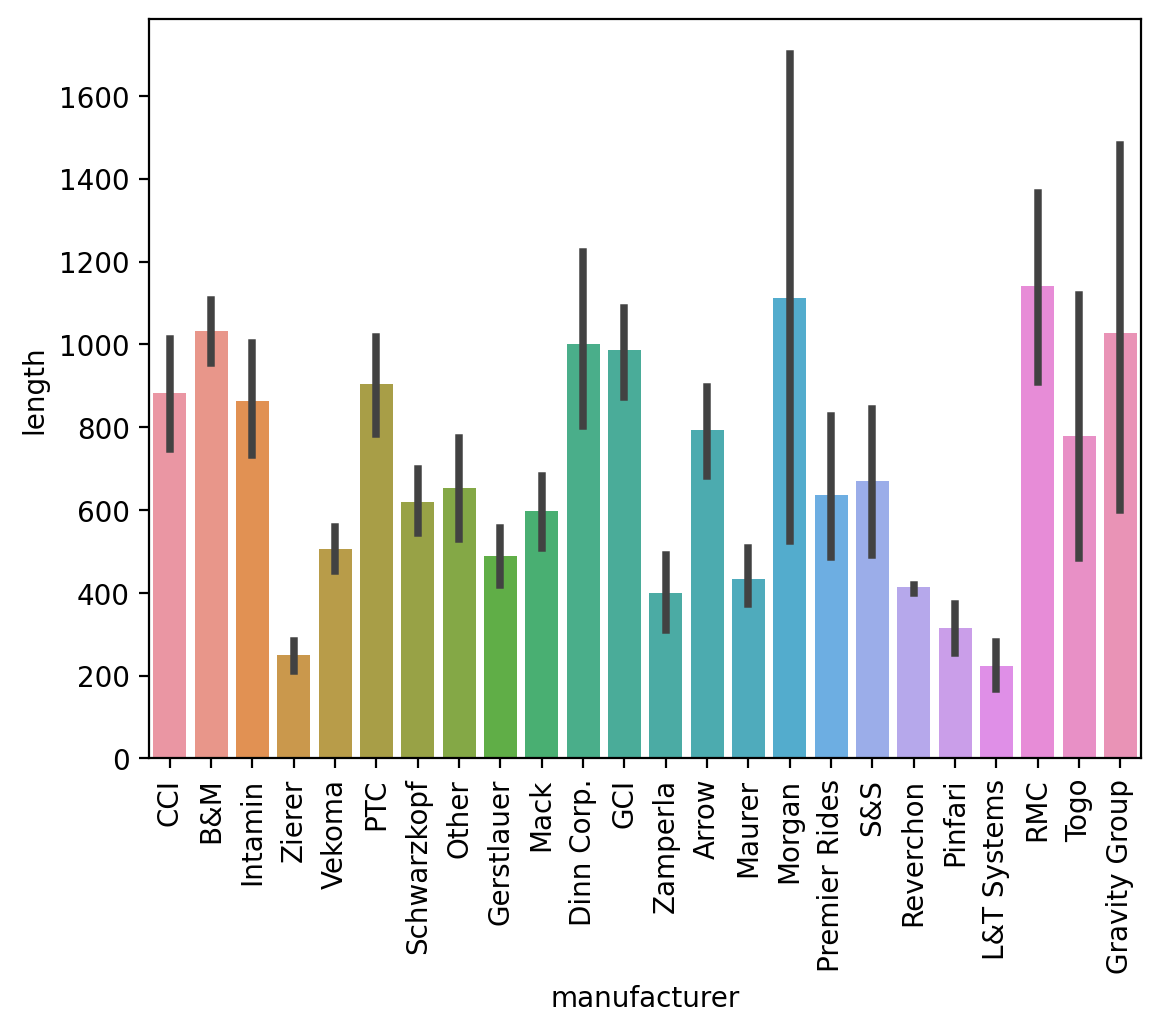

In [12]:
sns.barplot(data=train, x='manufacturer', y='length')
plt.xticks(rotation=90)
plt.show()


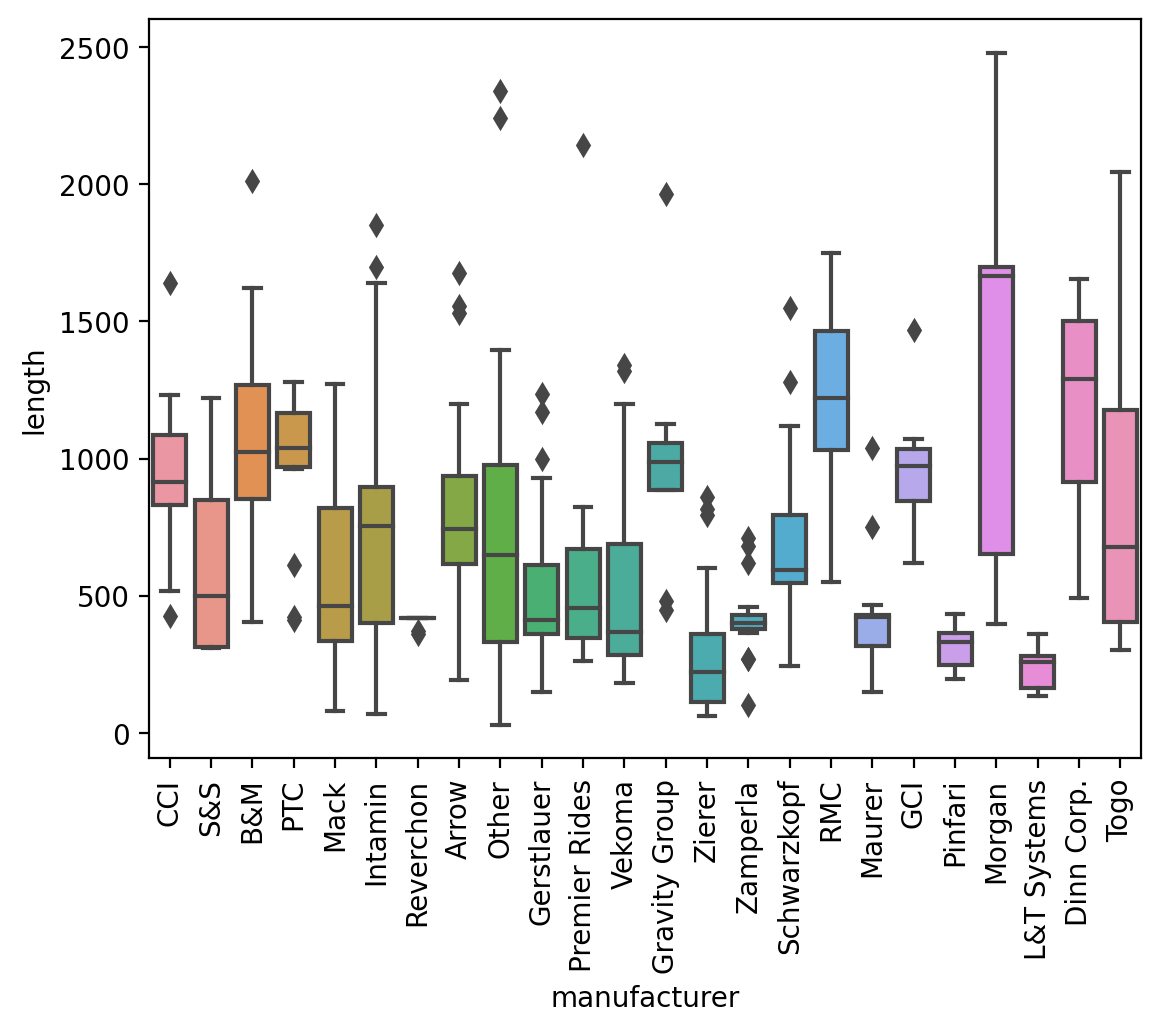

In [4]:
sns.boxplot(data=train, x='manufacturer', y='length')
plt.xticks(rotation=90)
plt.show()


<AxesSubplot: xlabel='steel_track', ylabel='length'>

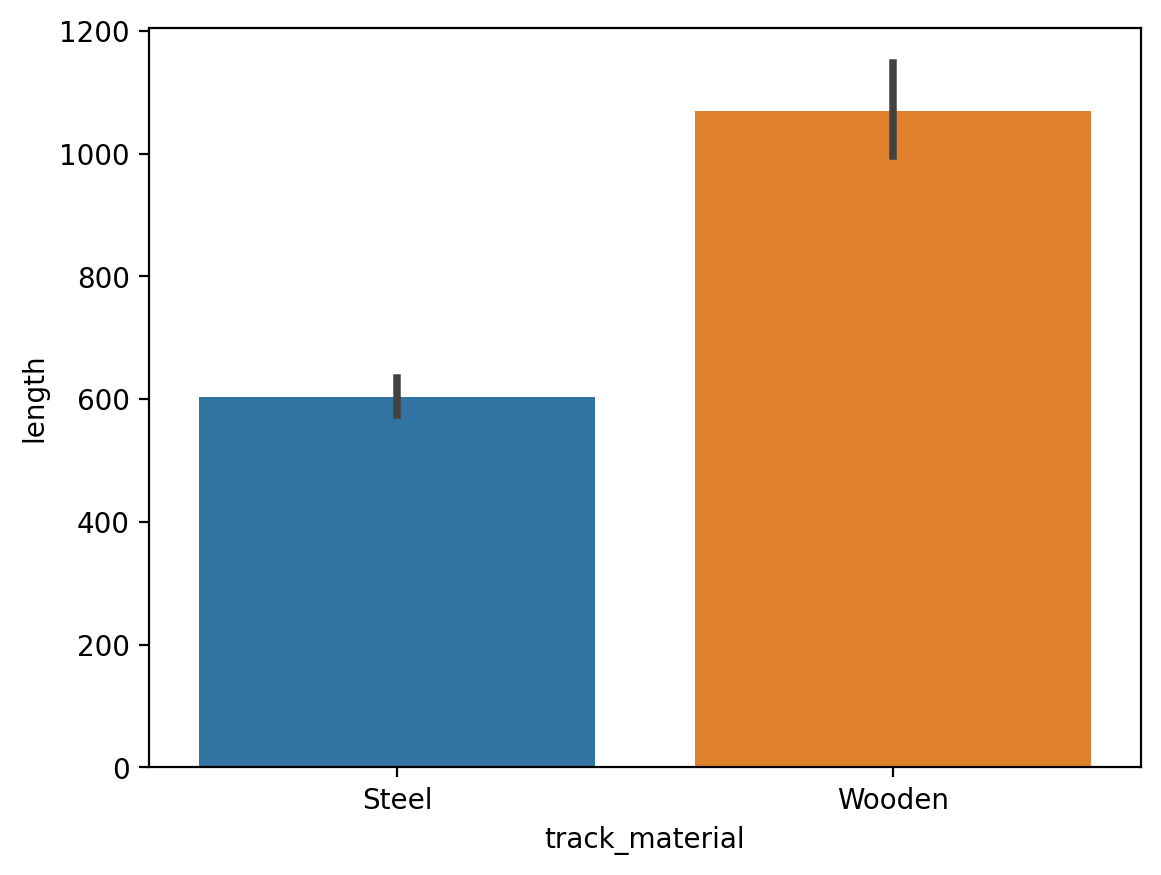

In [5]:
sns.barplot(data=train, x='steel_track', y='length')


### Is there a positive relationship between material type and length?
#### $H_0$: $\mu_{steel} \geq \mu_{wood} \geq \mu_{hybrid}$
#### $H_a$: $\mu_{steel} < \mu_{wood} < \mu_{hybrid}$

### Assumptions:
1. sets are independent
2. sets are normally distributed

<AxesSubplot: xlabel='length', ylabel='Count'>

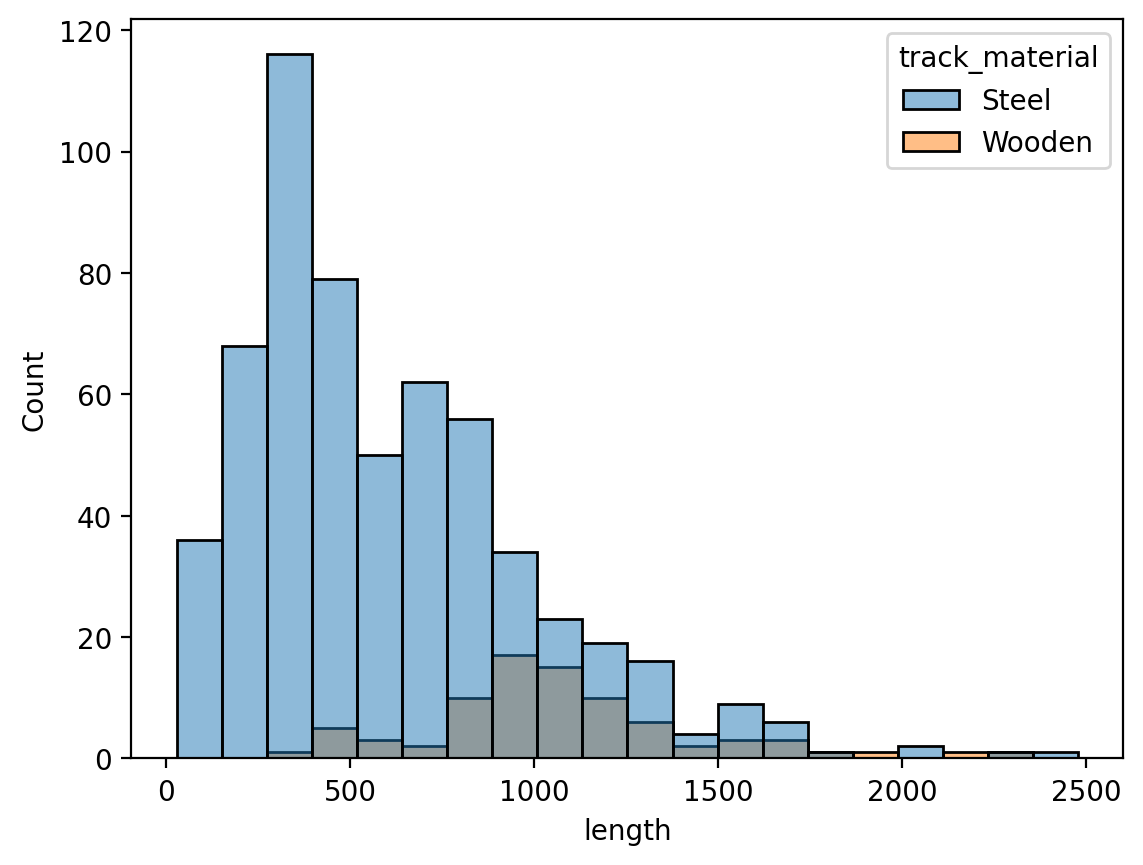

In [6]:
sns.histplot(data=train, x='length', hue='steel_track')


In [7]:
steel = train[train.steel_track == 'Steel']
wood = train[train.steel_track == 'Wooden']
steel.length.var(), wood.length.var()


(148780.79547110395, 129576.02716049385)

In [8]:
stats.levene(steel.length, wood.length)


LeveneResult(statistic=2.2361577956986496, pvalue=0.1352921420923287)

In [9]:
t, p = stats.ttest_ind(steel.length, wood.length, equal_var=False)
e.t_to_md(p, t)


## t = -10.817442410108276 

 ## p = 7.026846635063844e-19 

## Because t < 0 and $\alpha$ > p, we failed to   reject $H_0$

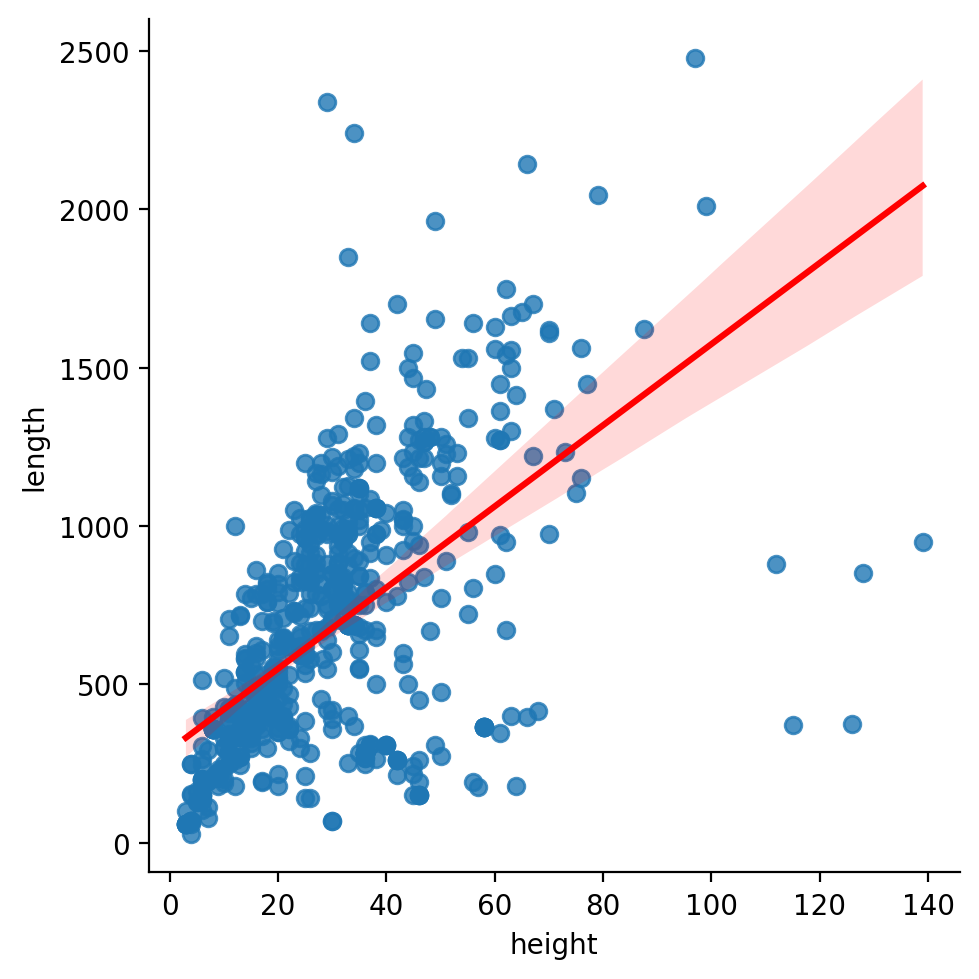

In [10]:
sns.lmplot(data=train, x='height', y='length', line_kws={'color': 'red'})


In [11]:
train.columns


Index(['name', 'steel_track', 'seating_type', 'speed', 'height', 'length',
       'num_inversions', 'manufacturer', 'park', 'status'],
      dtype='object')

In [15]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train['enc_seating'] = encoder.fit_transform(train.seating_type)

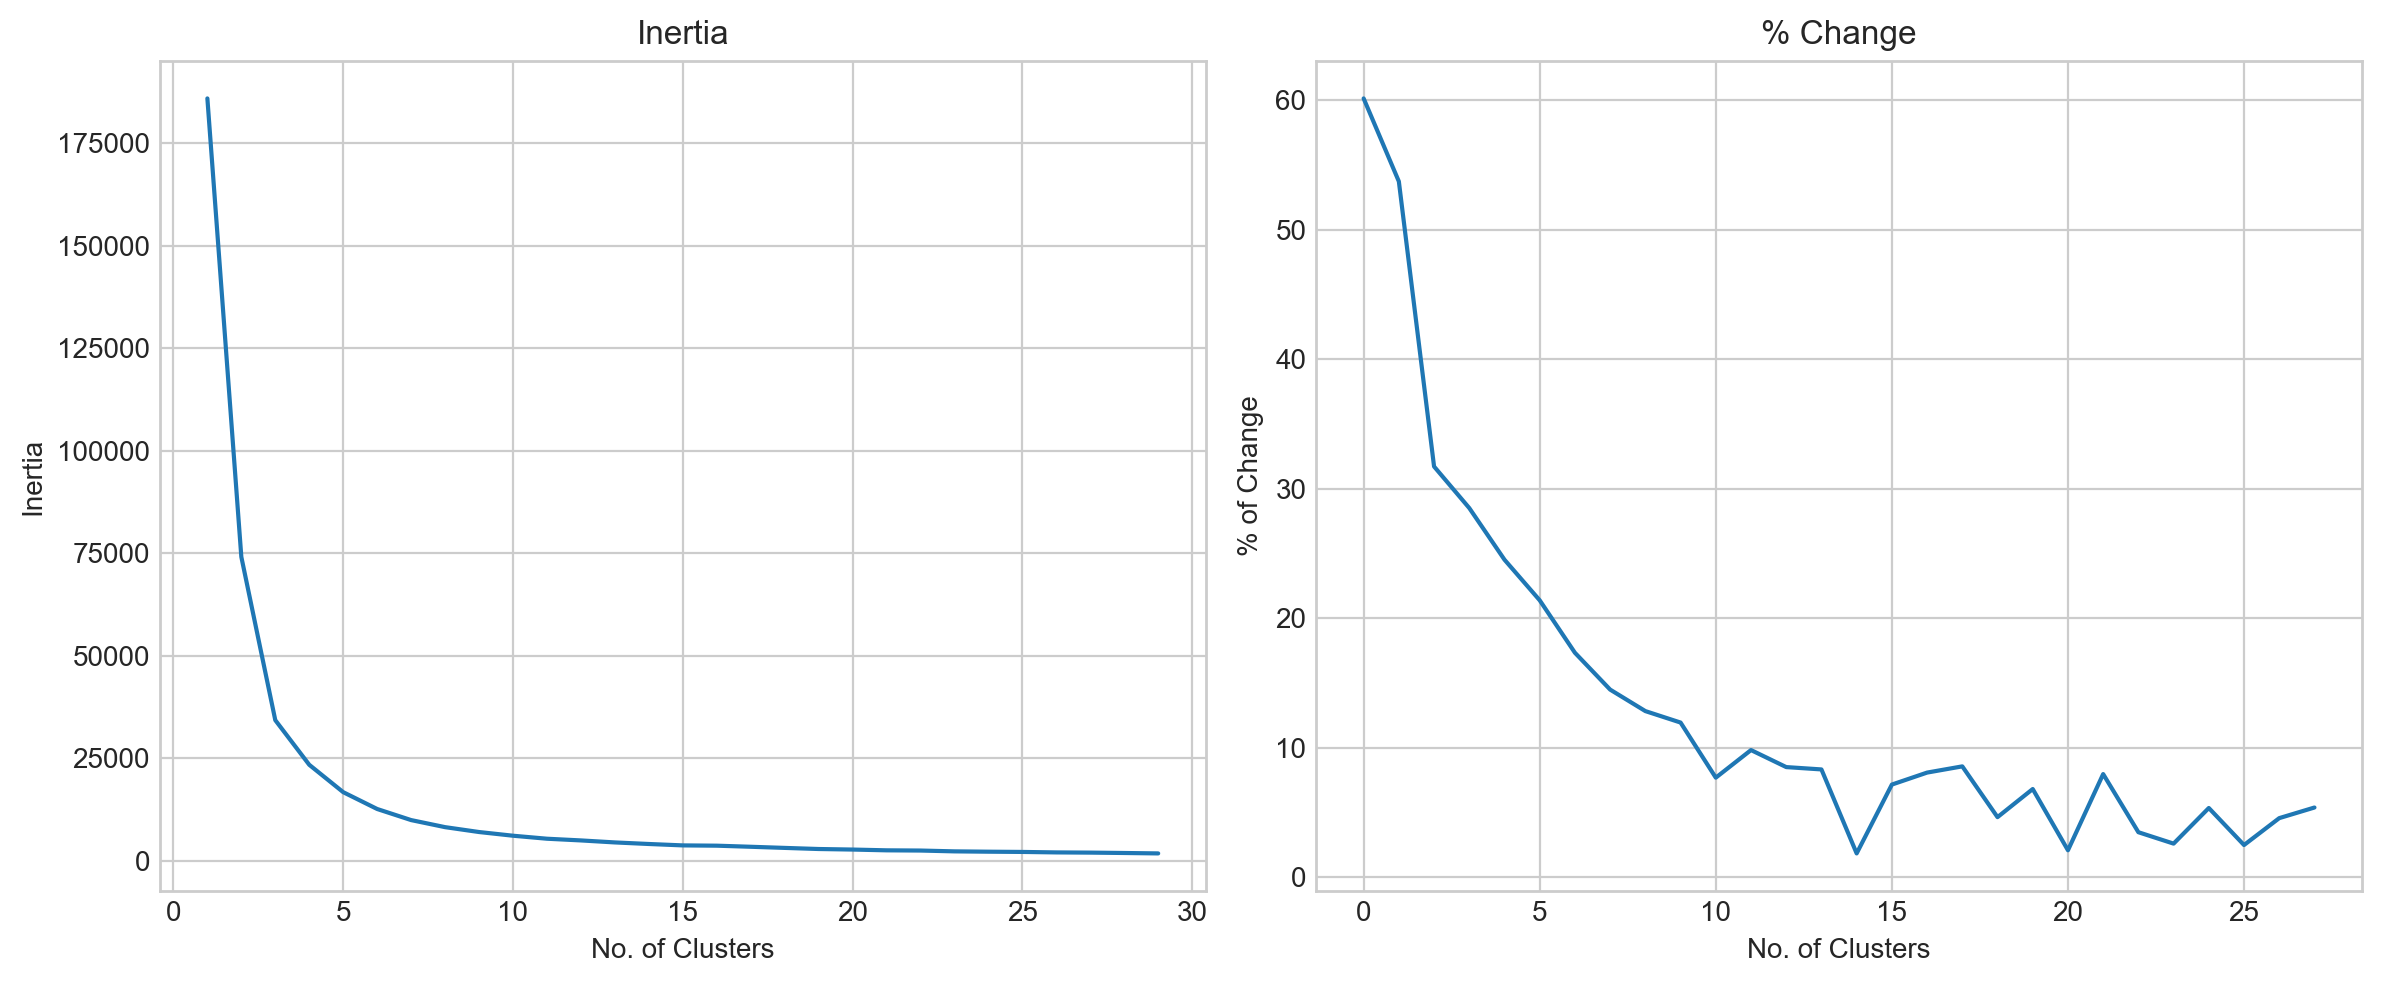

In [24]:
e.generate_elbow(train[['man_group','height','enc_seating']])


In [25]:
train['cluster'],_ = m.cluster(train[['man_group','height','enc_seating']],KMeans(10))

<AxesSubplot: xlabel='speed', ylabel='length'>

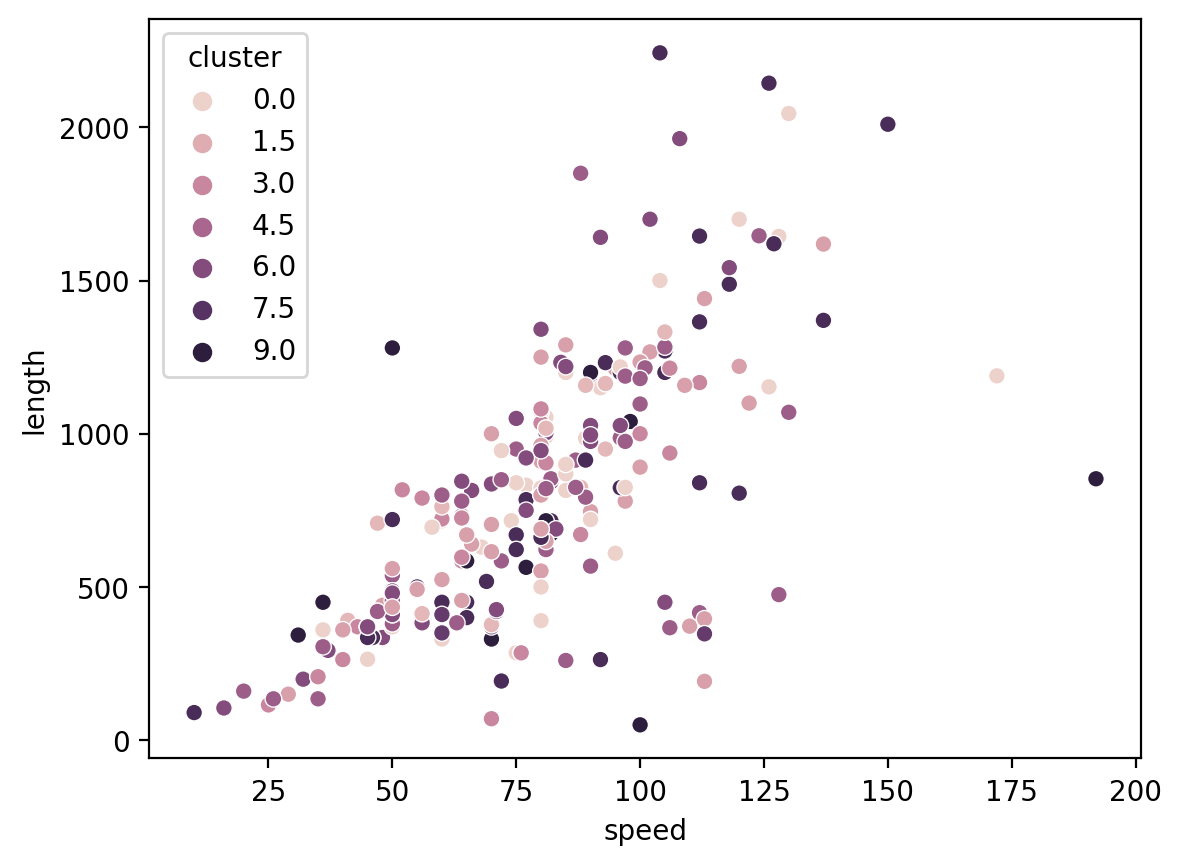

In [27]:
sns.scatterplot(data=train,x='speed',y='length',hue='cluster')

<AxesSubplot: xlabel='speed', ylabel='length'>

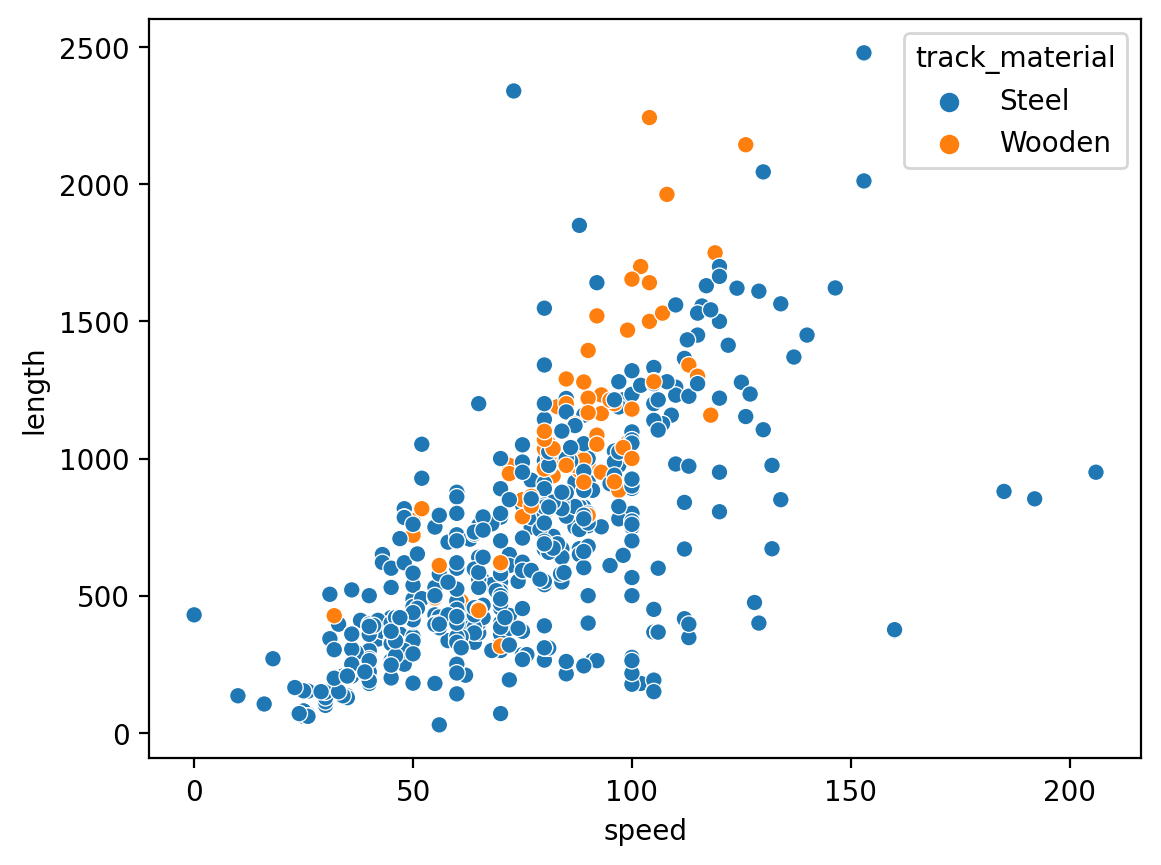

In [14]:
sns.scatterplot(data=train, x='speed', y='length', hue='steel_track')


# Observations
- Length
- Height
- Speed
- Manufacturer
- Track Construction


<AxesSubplot: xlabel='man_group', ylabel='length'>

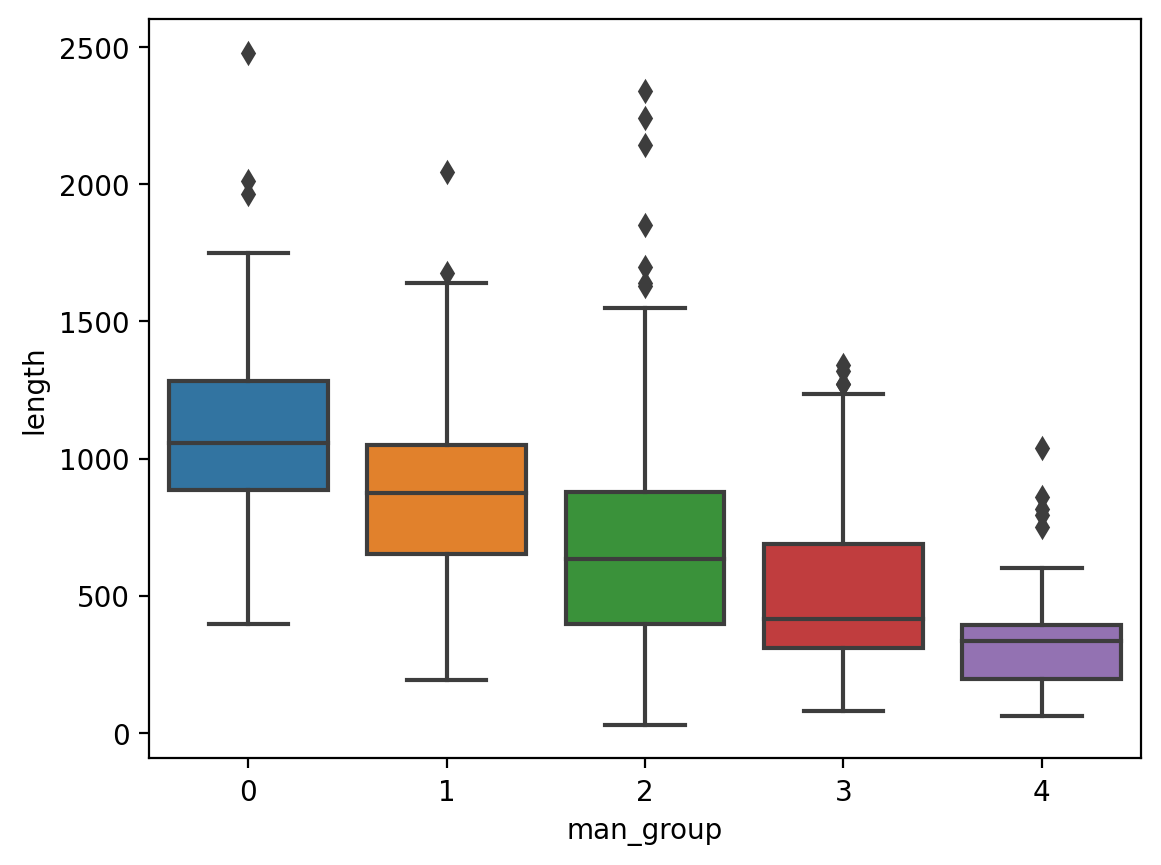

In [15]:
train.manufacturer = train.manufacturer.astype('string')
grouping = train.groupby('manufacturer').mean().sort_values(
    by='length', ascending=False).index.to_list()
train['man_group'] = -1
for i in range(5):
    train.loc[train.manufacturer.isin(grouping[i*5:(i+1)*5]), 'man_group'] = i
sns.boxplot(data=train, x='man_group', y='length')


#### Question: is there a statistical difference in the means of the man_group?
$H_0$: $\mu_{0} = \mu_1 = \mu_2 = \mu_3 = \mu_4$

$H_a$: $\mu_{0} = \mu_1 \neq \mu_2 \neq \mu_3 \neq \mu_4$

In [16]:
man_groups = []
for i in range(5):
    ser = train[train.man_group == i].length
    man_groups.append(ser)
t,p = stats.f_oneway(*man_groups)
e.t_to_md(p,t)


## t = 85.23730704704965 

 ## p = 2.4234017761014106e-58 

## Because t > 0 and $\alpha$ > p, we   reject $H_0$

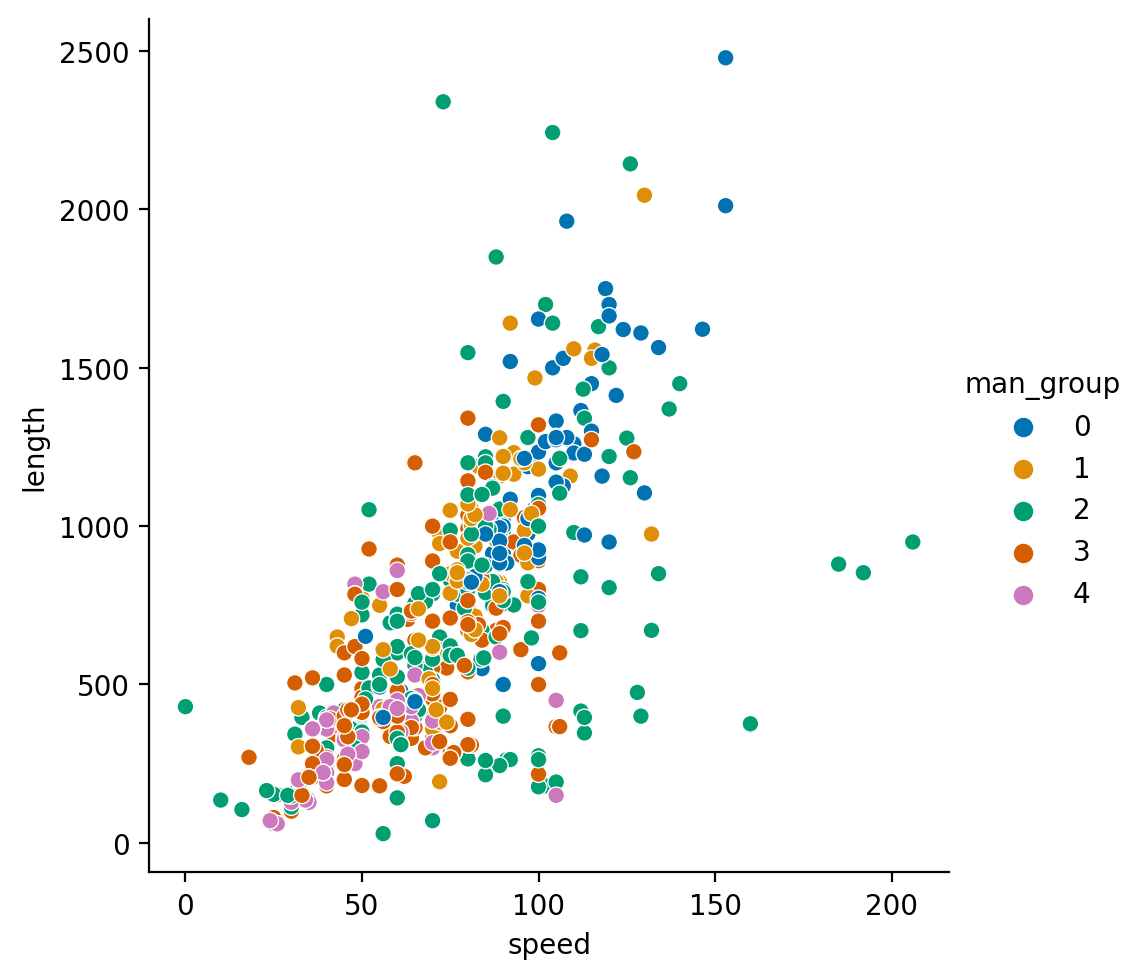

In [17]:
sns.relplot(data=train,x='speed',y='length',hue='man_group',palette='colorblind')

In [13]:
from sklearn.cluster import KMeans
reload(w)
train['height_speed'],kmeans = m.cluster(train[['speed','man_group']],kmeans=KMeans(7))


<AxesSubplot: xlabel='height_speed', ylabel='length'>

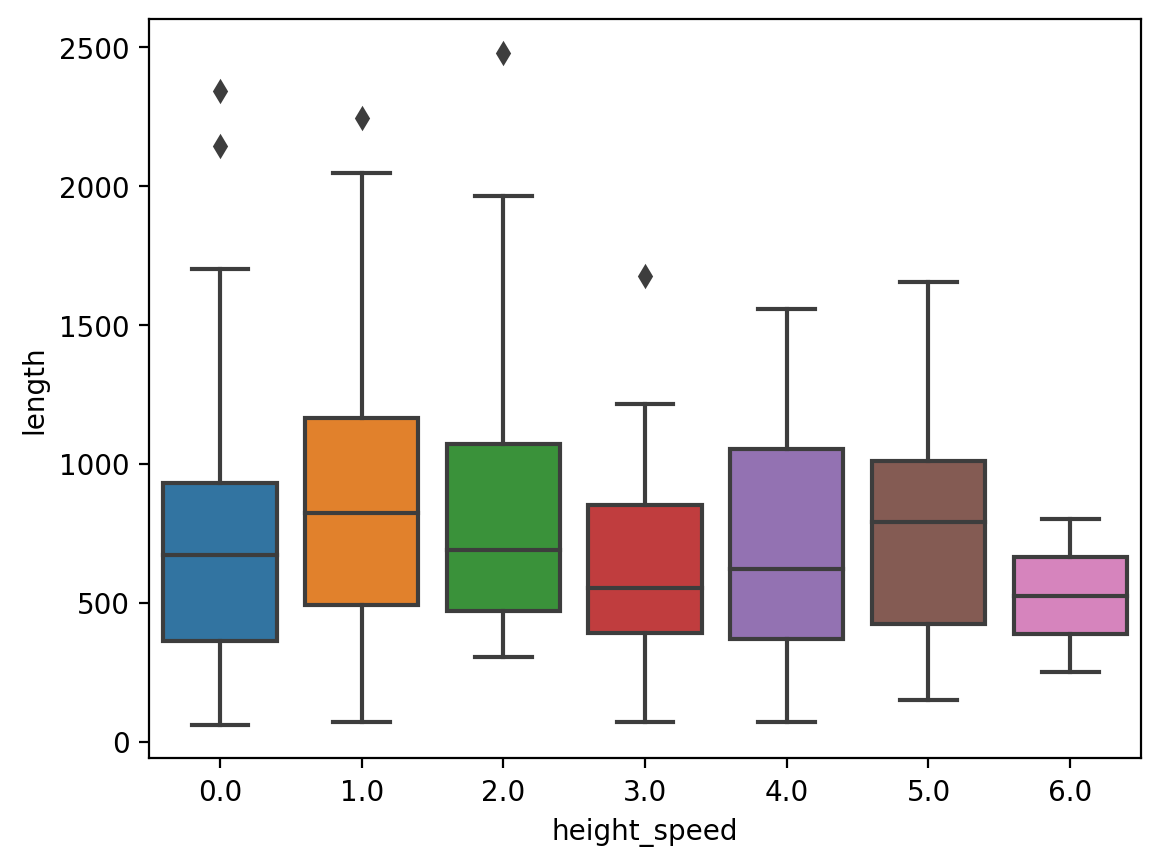

In [19]:
sns.boxplot(data=train,x='height_speed',y='length')

In [20]:
reload(e)
t,p = stats.levene(train.speed,train.length)
e.t_to_md(p,t)

## t = 945.5746907859782 

 ## p = 3.4039719762877634e-157 

## Because t > 0 and $\alpha$ > p, we   reject $H_0$

In [21]:
r,p = stats.spearmanr(train.speed,train.length)
e.p_to_md(p,r=r)

## p = 1.9523942023832474e-94
## r = 0.6884989926793289

## Because $\alpha$ > p,we  reject $H_0$

In [22]:
import model as m
md, base = m.select_baseline(train.length)
md

|                 |         SSE |    MSE |    RMSE |
|:----------------|------------:|-------:|--------:|
| Mean Baseline   | 1.12393e+08 | 169267 | 411.421 |
| Median Baseline | 1.15506e+08 | 173955 | 417.08  |
### Because mean outperformed median on all metrics,         we will use mean as our baseline

In [7]:
coaster_df = w.acquire_coasters()
coaster_df = w.prepare_coasters(coaster_df)
coaster_df.seating_type.value_counts()

Sit Down         898
Inverted          97
Spinning          50
Suspended         23
Floorless         21
Flying            21
Stand Up          16
4th Dimension     15
Water Coaster     14
Motorbike         10
Wing              10
Bobsleigh          9
Pipeline           3
Name: seating_type, dtype: int64